In [ ]:
 !pip install -q kaggle

from google.colab import files
print(" Please upload your kaggle.json file:")
uploaded = files.upload()

# Rename the uploaded file to kaggle.json
import shutil
shutil.move(list(uploaded.keys())[0], "kaggle.json")

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle authentication complete!")


 Please upload your kaggle.json file:


Saving kaggle.json to kaggle (1).json
✅ Kaggle authentication complete!


In [ ]:
# Download CT Kidney Dataset
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

# Remove existing directory to avoid conflicts
!rm -rf CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone

# Unzip dataset with automatic overwrite (no prompts)
!unzip -o -q ct-kidney-dataset-normal-cyst-tumor-and-stone.zip
print(" Dataset downloaded and extracted!")


Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
ct-kidney-dataset-normal-cyst-tumor-and-stone.zip: Skipping, found more recently modified local copy (use --force to force download)
 Dataset downloaded and extracted!


In [ ]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Visualization defaults
plt.style.use('default')
sns.set_palette("husl")
# %matplotlib inline  # Not needed in Colab

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ================================================================
# STEP 4: DATA LOADING WITH PROPER SPLITS (FIXED PATH DETECTION)
# ================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# First, let's find the correct dataset directory
print("🔍 Locating dataset directory...")

# Check common possible paths after extraction
possible_paths = [
    '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone',
    '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone',
    '/content/CT-KIDNEY-DATASET',
    '/content/kidney-dataset',
]

# Also check for any directory containing 'kidney' or 'CT'
for item in os.listdir('/content/'):
    item_path = os.path.join('/content/', item)
    if os.path.isdir(item_path):
        if any(keyword in item.lower() for keyword in ['kidney', 'ct', 'normal', 'cyst', 'tumor', 'stone']):
            possible_paths.append(item_path)

# Find the correct dataset directory
data_dir = None
for path in possible_paths:
    if os.path.exists(path):
        # Check if it contains class subdirectories
        try:
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            # Filter out common non-class directories
            class_subdirs = [d for d in subdirs if d not in ['.ipynb_checkpoints', '__pycache__', '.git']]

            if len(class_subdirs) >= 3:  # Should have at least 3 classes
                # Verify these directories contain images
                has_images = False
                for subdir in class_subdirs[:3]:  # Check first 3 subdirs
                    subdir_path = os.path.join(path, subdir)
                    if os.path.isdir(subdir_path):
                        files = os.listdir(subdir_path)
                        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                        if len(image_files) > 5:  # At least 5 images per class
                            has_images = True
                            break

                if has_images:
                    data_dir = path
                    print(f" Found dataset directory: {data_dir}")
                    print(f"   Classes found: {class_subdirs}")

                    # Show image counts for each class
                    for subdir in class_subdirs:
                        subdir_path = os.path.join(data_dir, subdir)
                        if os.path.isdir(subdir_path):
                            image_files = [f for f in os.listdir(subdir_path)
                                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                            print(f"    {subdir}: {len(image_files)} images")
                    break
        except Exception as e:
            print(f"   Error checking {path}: {e}")
            continue

# If still not found, manual search
if data_dir is None:
    print(" Could not find dataset automatically. Searching manually...")
    print("Available directories in /content/:")

    for item in os.listdir('/content/'):
        item_path = os.path.join('/content/', item)
        if os.path.isdir(item_path):
            print(f"   {item}/")
            try:
                subdirs = os.listdir(item_path)[:5]  # First 5 items
                for subdir in subdirs:
                    subdir_path = os.path.join(item_path, subdir)
                    if os.path.isdir(subdir_path):
                        print(f"     {subdir}/")
            except:
                pass

    # Try one more common pattern
    for root, dirs, files in os.walk('/content/'):
        if len(dirs) >= 3 and any('normal' in d.lower() for d in dirs):
            if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
                data_dir = root
                print(f" Found dataset at: {data_dir}")
                break

if data_dir is None:
    raise FileNotFoundError(" Could not locate dataset. Please verify the download and extraction completed successfully.")

# Verify the path one more time
if not os.path.exists(data_dir):
    raise FileNotFoundError(f" Dataset directory does not exist: {data_dir}")

print(f" Using dataset directory: {data_dir}")

# Dataset parameters
batch_size = 32
img_height = 224
img_width = 224

print("="*60)
print(" CREATING TENSORFLOW DATASETS")
print("="*60)

try:
    # Create train dataset (80% of data)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(img_height, img_width),
        validation_split=0.2,
        subset='training',
        seed=123,
        batch_size=batch_size
    )

    # Create validation dataset (20% of data)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(img_height, img_width),
        validation_split=0.2,
        subset='validation',
        seed=123,
        batch_size=batch_size
    )

    # Get class information
    class_names = train_ds.class_names
    num_classes = len(class_names)

    print(f" Datasets created successfully!")
    print(f" Classes: {class_names}")
    print(f" Number of classes: {num_classes}")
    print(f" Image size: {img_height}x{img_width}")
    print(f" Batch size: {batch_size}")

    # Create label mapping
    label_to_class_name = dict(zip(range(len(class_names)), class_names))
    print(f" Label Mapping: {label_to_class_name}")

except Exception as e:
    print(f" Error creating datasets: {e}")
    print("\n Dataset structure analysis:")

    if os.path.exists(data_dir):
        items = os.listdir(data_dir)
        print(f"Contents of {data_dir}:")
        for item in items:
            item_path = os.path.join(data_dir, item)
            if os.path.isdir(item_path):
                try:
                    file_count = len([f for f in os.listdir(item_path)
                                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
                    print(f"   {item}/: {file_count} images")
                except Exception as ex:
                    print(f"   {item}/: Error - {ex}")
            else:
                print(f"   {item}")

    raise

print("Step 4 completed successfully!")


🔍 Locating dataset directory...
 Found dataset directory: /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
   Classes found: ['Cyst', 'Tumor', 'Stone', 'Normal']
    Cyst: 3709 images
    Tumor: 2283 images
    Stone: 1377 images
    Normal: 5077 images
 Using dataset directory: /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
 CREATING TENSORFLOW DATASETS
Found 12446 files belonging to 4 classes.
Using 9957 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.
 Datasets created successfully!
 Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
 Number of classes: 4
 Image size: 224x224
 Batch size: 32
 Label Mapping: {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}
Step 4 completed successfully!


 Calculating class weights from the full training set...
   Classes found (indices): [0 1 2 3]
   Class distribution: [2972, 4076, 1097, 1812]  (order = ['Cyst', 'Normal', 'Stone', 'Tumor'])
 Class Weights (balanced & capped): {0: 0.8375672947510094, 1: 0.6107090284592738, 2: 2.2691431175934365, 3: 1.3737582781456954}


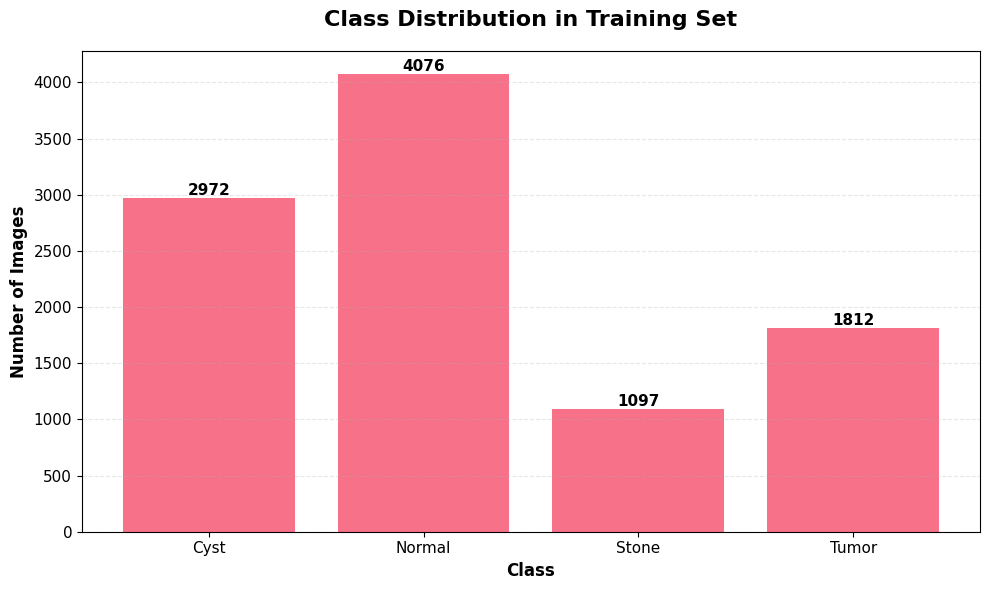

 Class distribution visualization complete.
Step 5 completed successfully!


In [ ]:
# ================================================================
# STEP 5: CALCULATE CLASS WEIGHTS FOR IMBALANCE (CLEAN + ACCURATE)
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

print(" Calculating class weights from the full training set...")

try:
    # Collect all training labels from the dataset
    all_labels = []
    for _, y in train_ds:
        all_labels.append(y.numpy())
    all_labels = np.concatenate(all_labels, axis=0).astype(int)

    # Basic stats
    unique = np.unique(all_labels)
    counts = np.bincount(all_labels, minlength=len(class_names))
    print(f"   Classes found (indices): {unique}")
    print(f"   Class distribution: {counts.tolist()}  (order = {class_names})")

    # Compute balanced class weights
    class_weights_array = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(len(class_names)),
        y=all_labels
    ).astype(float)

    # Cap extreme weights for stability (optional)
    class_weights_array = np.clip(class_weights_array, 0.5, 2.5)

    # Convert to dict for model.fit(...)
    class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}
    print(f" Class Weights (balanced & capped): {class_weights}")

except Exception as e:
    print(f" Error computing class weights from dataset: {e}")
    print(" Falling back to uniform weights (1.0 for all classes). Adjust if needed.")
    class_weights = {i: 1.0 for i in range(len(class_names))}

# ---- Visualization: Class distribution ----
try:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, counts if 'counts' in locals() else [1]*len(class_names))
    plt.title('Class Distribution in Training Set', fontsize=16, fontweight='bold', pad=18)
    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h, f'{int(h)}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    print(" Class distribution visualization complete.")
except Exception as e:
    print(f" Visualization error: {e}. Continuing...")

print("Step 5 completed successfully!")


In [ ]:
# ================================================================
# STEP 6: DATA PREPROCESSING & AUGMENTATION (VGG16-COMPATIBLE)
# ================================================================
print("="*60)
print(" SETTING UP DATA PREPROCESSING (VGG16)")
print("="*60)

from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications.vgg16 import preprocess_input

# Light, safe augmentation for medical CT
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, augment=False):
    """
    Cast to float32 -> (optional) augment -> VGG16 preprocess_input
    Note: We DO NOT use Rescaling(1./255) because VGG16's preprocess_input
    expects 0..255 float values, converts RGB->BGR, and subtracts ImageNet means.
    """
    def _prep(x, y):
        x = tf.cast(x, tf.float32)             # uint8 -> float32, still 0..255
        if augment:
            x = data_augmentation(x, training=True)
        x = preprocess_input(x)                # VGG16: BGR + mean subtraction
        return x, y

    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

# Apply preprocessing
train_ds = prepare_dataset(train_ds, augment=True)
val_ds   = prepare_dataset(val_ds, augment=False)

print("✅ Data preprocessing + augmentation applied (VGG16-compatible).")
print("\n Dataset verification:")
for images, labels in train_ds.take(1):
    print(f"  Training batch shape: {images.shape}, Labels shape: {labels.shape}")
    print(f"  Dtype: {images.dtype}, range approx: [{tf.reduce_min(images).numpy():.1f}, {tf.reduce_max(images).numpy():.1f}]")
for images, labels in val_ds.take(1):
    print(f"  Validation batch shape: {images.shape}, Labels shape: {labels.shape}")


 SETTING UP DATA PREPROCESSING (VGG16)
✅ Data preprocessing + augmentation applied (VGG16-compatible).

 Dataset verification:
  Training batch shape: (32, 224, 224, 3), Labels shape: (32,)
  Dtype: <dtype: 'float32'>, range approx: [-123.7, 151.1]
  Validation batch shape: (32, 224, 224, 3), Labels shape: (32,)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# ✅ Safe denormalization for VGG16-preprocessed images
# ---------------------------------------------------------------
def denormalize_vgg16(x):
    """
    Revert VGG16 preprocess_input (Caffe style) for visualization.
    Handles both normalized (0–1) and preprocessed (BGR) inputs.
    Returns float RGB image in [0,1].
    """
    x = x.astype(np.float32).copy()
    if np.max(x) <= 1.5:        # scaled 0–1
        x *= 255.0
    # Undo VGG16 mean subtraction (Caffe convention)
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]            # BGR → RGB
    x = np.clip(x / 255.0, 0, 1)
    return x

# ---------------------------------------------------------------
# ✅ Compute Grad-CAM heatmap (for a single image)
# ---------------------------------------------------------------
def make_gradcam_heatmap(model, img_batch, class_index=None, last_conv_name="block5_conv3"):
    """
    Generate Grad-CAM heatmap for a given image batch and model.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_batch)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)           # ReLU
    if tf.reduce_max(heatmap) != 0:
        heatmap /= tf.reduce_max(heatmap)      # normalize
    return heatmap.numpy()

# ---------------------------------------------------------------
# ✅ Compute Grad-CAM heatmaps for a batch of images (new function)
# ---------------------------------------------------------------
def _make_gradcam_batch_output(model, img_batch, last_conv_name="block5_conv3"):
    """
    Generate Grad-CAM heatmaps for a batch of images, focusing on the predicted class.
    Returns heatmaps, predicted class indices, and confidences for the batch.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        conv_outputs, predictions = grad_model(img_batch)
        predicted_classes = tf.cast(tf.argmax(predictions, axis=1), tf.int32) # Cast to int32
        # Gather the score for the predicted class for each image in the batch
        indices = tf.stack([tf.range(tf.shape(predictions)[0], dtype=tf.int32), predicted_classes], axis=1)
        loss = tf.gather_nd(predictions, indices)

    # Calculate gradients for the predicted class scores
    grads = tape.gradient(loss, conv_outputs)

    # Global average pool gradients for each image in the batch
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    # Expand dims for broadcasting: (batch_size, 1, 1, channels) * (batch_size, H, W, channels)
    pooled_grads = tf.expand_dims(tf.expand_dims(pooled_grads, axis=1), axis=1)

    # Multiply conv_outputs by pooled_grads to get raw heatmaps
    heatmaps = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Apply ReLU
    heatmaps = tf.maximum(heatmaps, 0)

    # Normalize heatmaps per image in the batch
    max_vals = tf.reduce_max(heatmaps, axis=(1, 2), keepdims=True)
    min_vals = tf.reduce_min(heatmaps, axis=(1, 2), keepdims=True)
    # Add a small epsilon to avoid division by zero
    normalized_heatmaps = (heatmaps - min_vals) / (max_vals - min_vals + tf.keras.backend.epsilon())

    # Reshape for consistency if needed, e.g., (batch, H, W, 1)
    normalized_heatmaps = tf.expand_dims(normalized_heatmaps, axis=-1)

    confidences = tf.reduce_max(predictions, axis=1)

    return normalized_heatmaps.numpy(), predicted_classes.numpy(), confidences.numpy()

# ---------------------------------------------------------------
# ✅ Overlay heatmap on image (OpenCV safe)
# ---------------------------------------------------------------
def overlay_heatmap_on_image(heatmap, image, alpha=0.4):
    """
    Overlay a Grad-CAM heatmap onto an RGB image safely.
    """
    heatmap = np.squeeze(heatmap)
    heatmap = np.nan_to_num(heatmap)
    heatmap = np.clip(heatmap, 0, 1)
    heatmap_uint8 = np.uint8(255 * heatmap)

    # Apply color map
    hm_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB)

    # Prepare base image
    if image.dtype != np.uint8:
        base_img = (denormalize_vgg16(image) * 255).astype(np.uint8)
    else:
        base_img = image.copy()

    hm_color = cv2.resize(hm_color, (base_img.shape[1], base_img.shape[0]))
    overlay = cv2.addWeighted(hm_color, alpha, base_img, 1 - alpha, 0)
    return overlay

# ---------------------------------------------------------------
# ✅ Single-image Grad-CAM visualizer (for tests & demos)
# ---------------------------------------------------------------
def visualize_gradcam_single(model, img, class_names, last_conv_name="block5_conv3"):
    """
    Display Original | Heatmap | Overlay for one image.
    """
    heatmap = make_gradcam_heatmap(model, img[np.newaxis, ...], last_conv_name=last_conv_name)
    overlay = overlay_heatmap_on_image(heatmap, img)

    preds = model.predict(img[np.newaxis, ...])[0]
    pred_idx = np.argmax(preds)
    conf = np.max(preds)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(denormalize_vgg16(img))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay\nPred: {class_names[pred_idx]} ({conf:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Predicted Class → {class_names[pred_idx]} | Confidence → {conf*100:.2f}%")
    return heatmap, overlay

print("✅ Grad-CAM utilities loaded successfully.")

✅ Grad-CAM utilities loaded successfully.


In [ ]:
# ================================================================
# STEP 8: BUILD VGG16 CLASSIFICATION MODEL (CLEAN + GRAD-CAM READY)
# ================================================================

print("="*60)
print("🏗️ BUILDING VGG16 CLASSIFICATION MODEL")
print("="*60)

from tensorflow.keras import Model, Sequential, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

LAST_CONV_LAYER_NAME = "block5_conv3"  # for Grad-CAM

def build_vgg16_classifier(input_shape=(224, 224, 3), num_classes=4):
    # Base model (pretrained ImageNet)
    base_model = VGG16(
        include_top=False,
        input_shape=input_shape,
        weights="imagenet"
    )
    # Freeze base for initial training
    base_model.trainable = False

    # Classification head
    x = layers.GlobalAveragePooling2D(name="gap")(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="predictions")(x)

    model = Model(inputs=base_model.input, outputs=outputs, name="VGG16_Classifier")

    # Sanity check for Grad-CAM layer
    assert any(l.name == LAST_CONV_LAYER_NAME for l in base_model.layers), \
        f"Expected conv layer '{LAST_CONV_LAYER_NAME}' not found in VGG16."

    return model, base_model

vgg16_model, vgg16_base = build_vgg16_classifier(input_shape=(img_height, img_width, 3),
                                                 num_classes=num_classes)
vgg16_model.summary()

# Compile (frozen base): higher LR is okay here
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ VGG16 classifier built (frozen base). Grad-CAM target layer: block5_conv3")


🏗️ BUILDING VGG16 CLASSIFICATION MODEL


Model: "VGG16_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

✅ VGG16 classifier built (frozen base). Grad-CAM target layer: block5_conv3


In [ ]:
# ================================================================
# STEP 9: GRAD-CAM UTILITY FUNCTIONS (FINAL FIXED VERSION)
# ================================================================
print("=" * 60)
print("🧠 LOADING GRAD-CAM UTILITIES (FINAL FIXED)")
print("=" * 60)

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# ✅ Safe denormalization for VGG16-preprocessed images
# ---------------------------------------------------------------
def denormalize_vgg16(x):
    """
    Revert VGG16 preprocess_input (Caffe style) for visualization.
    Handles both normalized (0–1) and preprocessed (BGR) inputs.
    Returns float RGB image in [0,1].
    """
    x = x.astype(np.float32).copy()
    if np.max(x) <= 1.5:        # scaled 0–1
        x *= 255.0
    # Undo VGG16 mean subtraction (Caffe convention)
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]            # BGR → RGB
    x = np.clip(x / 255.0, 0, 1)
    return x

# ---------------------------------------------------------------
# ✅ Compute Grad-CAM heatmap
# ---------------------------------------------------------------
def make_gradcam_heatmap(model, img_batch, class_index=None, last_conv_name="block5_conv3"):
    """
    Generate Grad-CAM heatmap for a given image batch and model.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_batch)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)           # ReLU
    if tf.reduce_max(heatmap) != 0:
        heatmap /= tf.reduce_max(heatmap)      # normalize
    return heatmap.numpy()

# ---------------------------------------------------------------
# ✅ Overlay heatmap on image (OpenCV safe)
# ---------------------------------------------------------------
def overlay_heatmap_on_image(heatmap, image, alpha=0.4):
    """
    Overlay a Grad-CAM heatmap onto an RGB image safely.
    """
    heatmap = np.squeeze(heatmap)
    heatmap = np.nan_to_num(heatmap)
    heatmap = np.clip(heatmap, 0, 1)
    heatmap_uint8 = np.uint8(255 * heatmap)

    # Apply color map
    hm_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB)

    # Prepare base image
    if image.dtype != np.uint8:
        base_img = (denormalize_vgg16(image) * 255).astype(np.uint8)
    else:
        base_img = image.copy()

    hm_color = cv2.resize(hm_color, (base_img.shape[1], base_img.shape[0]))
    overlay = cv2.addWeighted(hm_color, alpha, base_img, 1 - alpha, 0)
    return overlay

# ---------------------------------------------------------------
# ✅ Single-image Grad-CAM visualizer (for tests & demos)
# ---------------------------------------------------------------
def visualize_gradcam_single(model, img, class_names, last_conv_name="block5_conv3"):
    """
    Display Original | Heatmap | Overlay for one image.
    """
    heatmap = make_gradcam_heatmap(model, img[np.newaxis, ...], last_conv_name=last_conv_name)
    overlay = overlay_heatmap_on_image(heatmap, img)

    preds = model.predict(img[np.newaxis, ...])[0]
    pred_idx = np.argmax(preds)
    conf = np.max(preds)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(denormalize_vgg16(img))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay\nPred: {class_names[pred_idx]} ({conf:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Predicted Class → {class_names[pred_idx]} | Confidence → {conf*100:.2f}%")
    return heatmap, overlay

print("✅ Grad-CAM utilities loaded successfully.")


🧠 LOADING GRAD-CAM UTILITIES (FINAL FIXED)
✅ Grad-CAM utilities loaded successfully.


🧠 QUICK TEST: GRAD-CAM DEMONSTRATION ON ONE VALIDATION IMAGE
Selected Sample Index: 14 | True Class: Tumor


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_4']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


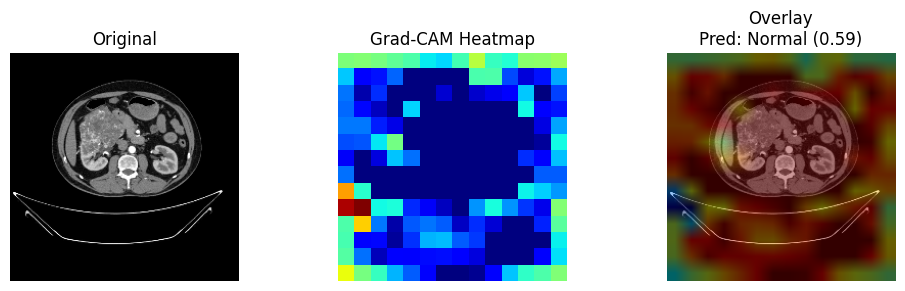

Predicted Class → Normal | Confidence → 58.58%


In [ ]:
# ================================================================
# STEP 9B: QUICK GRAD-CAM TEST DEMONSTRATION
# ================================================================
print("=" * 60)
print("🧠 QUICK TEST: GRAD-CAM DEMONSTRATION ON ONE VALIDATION IMAGE")
print("=" * 60)

import random, numpy as np

# Pick a random sample from the validation dataset
for images, labels in val_ds.take(1):
    idx = random.randint(0, len(images) - 1)
    test_img = images[idx].numpy()
    test_label = int(labels[idx].numpy())
    break

print(f"Selected Sample Index: {idx} | True Class: {class_names[test_label]}")

# Run visualization
_ = visualize_gradcam_single(
    vgg16_model,
    test_img,
    class_names,
    last_conv_name="block5_conv3"
)


In [ ]:
# ================================================================
# STEP 10: SETUP TRAINING CALLBACKS
# ================================================================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, TensorBoard
import time

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,                # tuned for ~25-30 epochs
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # reduce LR when loss stagnates
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_vgg16_model.keras',   # SavedModel format
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,   # keep optimizer state too; fine for .keras
    mode='max',
    verbose=1
)

csv_logger = CSVLogger('training_log.csv', append=True)

logdir = f"logs/vgg16_{int(time.time())}"
tb = TensorBoard(log_dir=logdir)

callbacks_list = [early_stop, reduce_lr, checkpoint, csv_logger, tb]

print("✅ Training callbacks configured:")
print("   • EarlyStopping(patience=8, monitor=val_accuracy)")
print("   • ReduceLROnPlateau(patience=4, monitor=val_loss)")
print("   • ModelCheckpoint(best by val_accuracy)")
print(f"   • CSVLogger -> training_log.csv")
print(f"   • TensorBoard -> {logdir}")


✅ Training callbacks configured:
   • EarlyStopping(patience=8, monitor=val_accuracy)
   • ReduceLROnPlateau(patience=4, monitor=val_loss)
   • ModelCheckpoint(best by val_accuracy)
   • CSVLogger -> training_log.csv
   • TensorBoard -> logs/vgg16_1762787618


In [ ]:
# ================================================================
# STEP 11: TRAIN VGG16 CLASSIFICATION MODEL (TWO-PHASE)
# ================================================================

print("="*60)
print(" TRAINING VGG16 CLASSIFICATION MODEL")
print("="*60)
print(" Phase 1: Train classifier head (base frozen) @ lr=1e-3")
print(" Phase 2: Fine-tune top VGG blocks (partial unfreeze) @ lr=1e-5")
print("="*60)

# ---- Phase 1: Train head (base frozen) ----
epochs_phase1 = 15  # you can raise to ~25 if needed
history_p1 = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_phase1,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

# Load best from Phase 1 (by val_accuracy)
try:
    best_path = "best_vgg16_model.keras"
    vgg16_model = tf.keras.models.load_model(best_path)
    print(f"✅ Loaded best model from Phase 1: {best_path}")
except Exception as e:
    print(f"⚠️ Could not reload best checkpoint: {e}. Continuing with in-memory model.")

# ---- Phase 2: Fine-tune top VGG layers ----
# Unfreeze last block(s) for fine-tuning
unfreeze = False
for layer in vgg16_model.layers:
    if isinstance(layer, tf.keras.Model) and layer.name.startswith("vgg16"):
        for l in layer.layers:
            # Unfreeze block5 (and optionally block4) for more capacity
            if l.name.startswith("block5_"):  # change to ('block4_', 'block5_') to unfreeze both
                l.trainable = True
                unfreeze = True
            else:
                l.trainable = False  # keep the rest frozen
        break

if unfreeze:
    print("🔓 Unfroze VGG16 block5 layers for fine-tuning.")
else:
    print("⚠️ Warning: did not find VGG16 sub-layers to unfreeze. Check model structure.")

# Recompile with a smaller learning rate for fine-tuning
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

epochs_phase2 = 10  # fine-tuning epochs; adjust as needed
history_p2 = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_phase2,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

print("✅ VGG16 classification training completed (frozen + fine-tune).")



 TRAINING VGG16 CLASSIFICATION MODEL
 Phase 1: Train classifier head (base frozen) @ lr=1e-3
 Phase 2: Fine-tune top VGG blocks (partial unfreeze) @ lr=1e-5
Epoch 1/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5928 - loss: 1.1227
Epoch 1: val_accuracy improved from -inf to 0.85416, saving model to best_vgg16_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 197s 565ms/step - accuracy: 0.5931 - loss: 1.1218 - val_accuracy: 0.8542 - val_loss: 0.4023 - learning_rate: 0.0010
Epoch 2/15
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8179 - loss: 0.4926
Epoch 2: val_accuracy did not improve from 0.85416
312/312 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step - accuracy: 0.8180 - loss: 0.4924 - val_accuracy: 0.8509 - val_loss: 0.4158 - learning_rate: 0.0010
Epoch 3/15
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8582 - loss: 0.3709
Epoch 3: val_accuracy improved from 0.85416 to 0.86099, saving model to best_vgg16_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 68s 219ms/step - accura

In [ ]:
# ================================================================
# STEP 12: SAVE VGG16 MODEL AND TRAINING HISTORY (FIXED)
# ================================================================
import pandas as pd

print("="*60)
print("💾 SAVING VGG16 MODEL AND TRAINING HISTORY")
print("="*60)

# Combine both training phases into one history DataFrame
def combine_histories(h1, h2):
    """Merge two Keras History objects into one DataFrame."""
    hist1 = pd.DataFrame(h1.history) if h1 else pd.DataFrame()
    hist2 = pd.DataFrame(h2.history) if h2 else pd.DataFrame()
    hist = pd.concat([hist1, hist2], ignore_index=True)
    return hist

history_df = combine_histories(
    locals().get('history_p1', None),
    locals().get('history_p2', None)
)

# Save training history
history_path = "vgg16_training_history.csv"
history_df.to_csv(history_path, index=False)
print(f"📊 Training history saved: {history_path} ({len(history_df)} epochs total)")

# Save final fine-tuned model
model_path = "vgg16_kidney_classifier_final.keras"
vgg16_model.save(model_path)
print(f"✅ Final model saved: {model_path}")

print("\nVGG16 Training Complete!")


💾 SAVING VGG16 MODEL AND TRAINING HISTORY
📊 Training history saved: vgg16_training_history.csv (24 epochs total)
✅ Final model saved: vgg16_kidney_classifier_final.keras

VGG16 Training Complete!


 TRAINING & VALIDATION METRICS VISUALIZATION


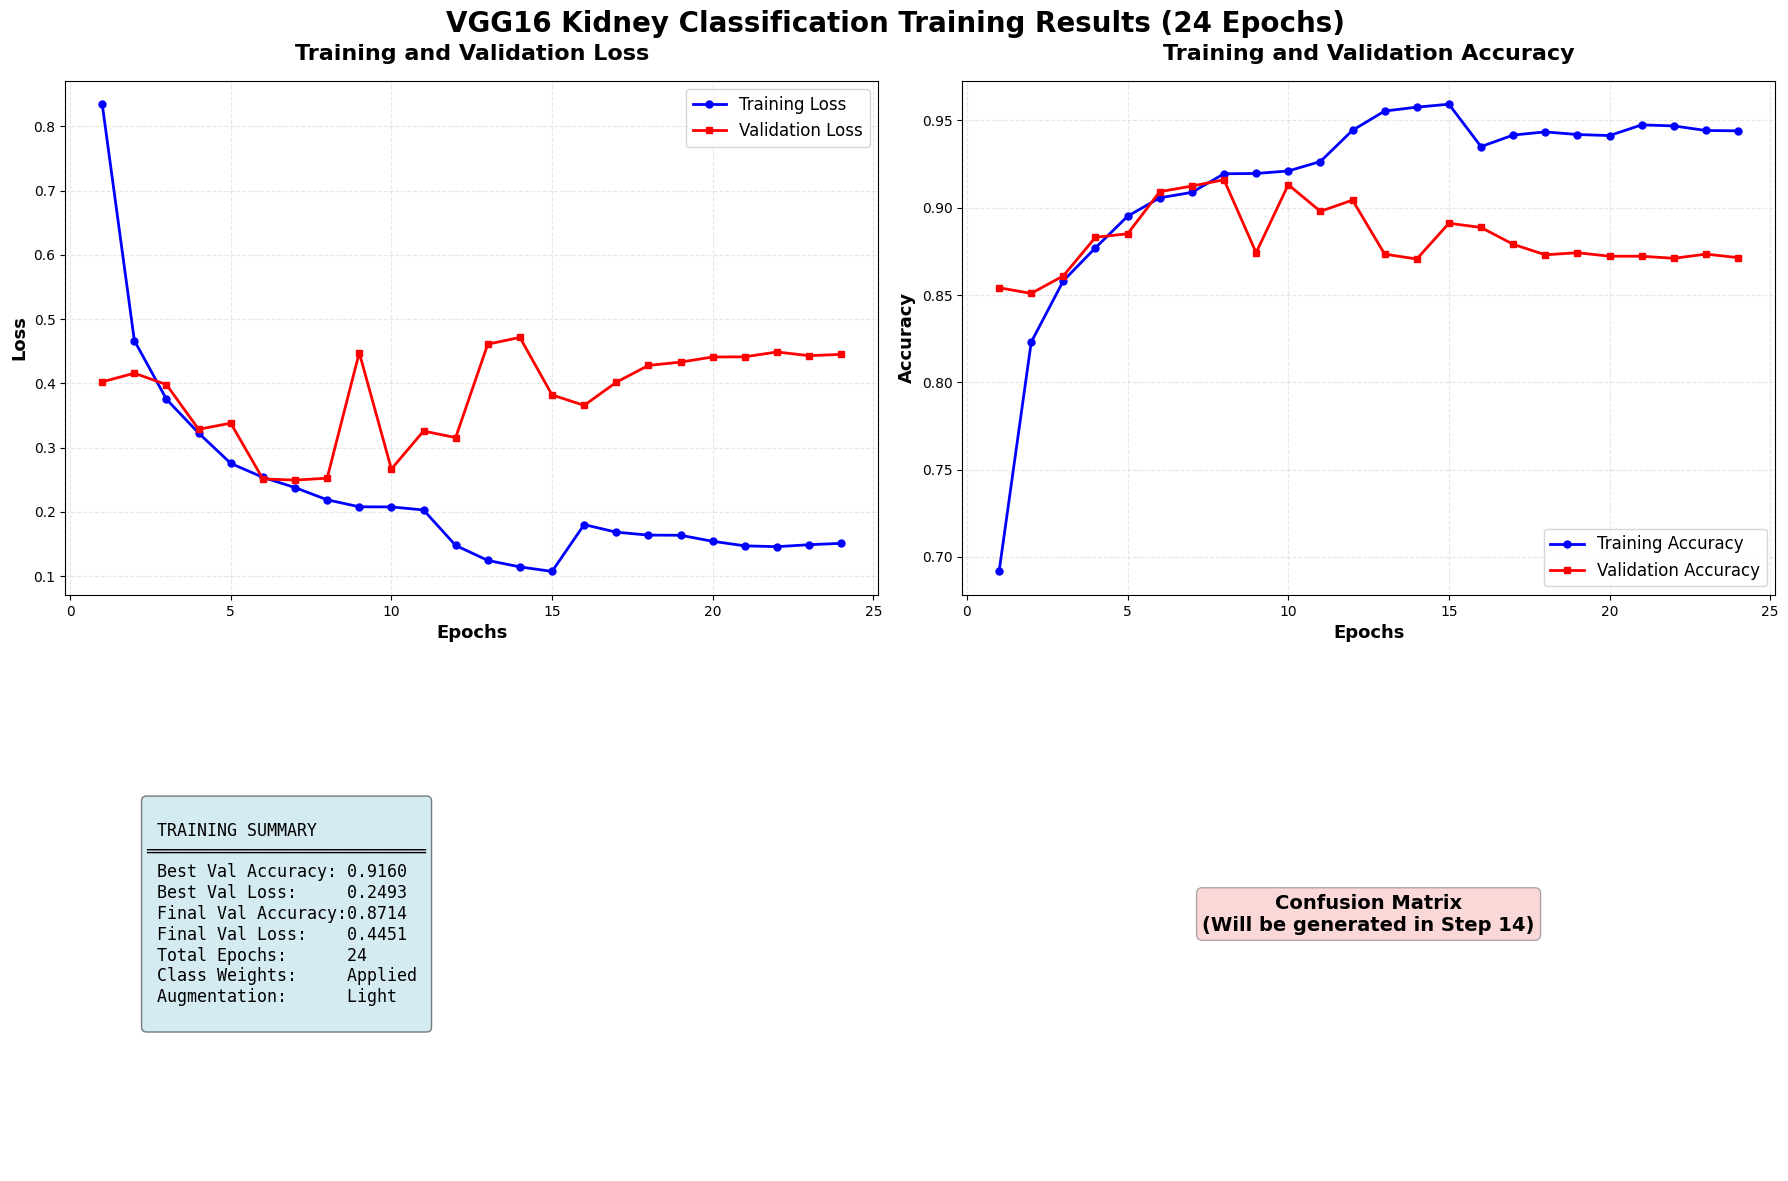

 Best Validation Accuracy: 0.9160
 Best Validation Loss:     0.2493
 Final Validation Accuracy: 0.8714
 Training completed in 24 epochs


In [ ]:
# ================================================================
# STEP 13: TRAINING & VALIDATION METRICS VISUALIZATION (FIXED)
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print(" TRAINING & VALIDATION METRICS VISUALIZATION")
print("="*60)

# Load merged history from Step 12
hist_path = "vgg16_training_history.csv"
history_df = pd.read_csv(hist_path)

# Extract metrics safely
train_loss = history_df.get('loss', pd.Series(dtype=float)).tolist()
val_loss   = history_df.get('val_loss', pd.Series(dtype=float)).tolist()
train_acc  = history_df.get('accuracy', pd.Series(dtype=float)).tolist()
val_acc    = history_df.get('val_accuracy', pd.Series(dtype=float)).tolist()
lr_values  = history_df.get('lr', pd.Series(dtype=float)).tolist() if 'lr' in history_df.columns else None

epochs_range = range(1, len(train_loss) + 1)

fig = plt.figure(figsize=(18, 12))

# Training & Validation Loss
ax1 = plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_loss, 'b-o', label='Training Loss', linewidth=2.0, markersize=5)
plt.plot(epochs_range, val_loss,   'r-s', label='Validation Loss', linewidth=2.0, markersize=5)
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Epochs', fontsize=13, fontweight='bold')
plt.ylabel('Loss', fontsize=13, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')

# Training & Validation Accuracy
ax2 = plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_acc, 'b-o', label='Training Accuracy', linewidth=2.0, markersize=5)
plt.plot(epochs_range, val_acc,   'r-s', label='Validation Accuracy', linewidth=2.0, markersize=5)
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Epochs', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')

# Learning Rate (if available)
ax3 = plt.subplot(2, 2, 3)
if lr_values is not None and len(lr_values) == len(train_loss):
    plt.plot(epochs_range, lr_values, 'g-^', label='Learning Rate', linewidth=2.0, markersize=5)
    plt.title('Learning Rate Schedule', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Epochs', fontsize=13, fontweight='bold')
    plt.ylabel('Learning Rate', fontsize=13, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
else:
    # Summary box
    plt.axis('off')
    if val_acc and val_loss:
        summary_text = f"""
 TRAINING SUMMARY
════════════════════════════
 Best Val Accuracy: {max(val_acc):.4f}
 Best Val Loss:     {min(val_loss):.4f}
 Final Val Accuracy:{val_acc[-1]:.4f}
 Final Val Loss:    {val_loss[-1]:.4f}
 Total Epochs:      {len(epochs_range)}
 Class Weights:     Applied
 Augmentation:      Light
        """
    else:
        summary_text = "No metrics found in history file."
    plt.text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
             va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.5))

# Confusion matrix placeholder (will fill in STEP 14)
ax4 = plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, 'Confusion Matrix\n(Will be generated in Step 14)',
         ha='center', va='center', fontsize=14, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.3))
plt.axis('off')

plt.suptitle(f'VGG16 Kidney Classification Training Results ({len(epochs_range)} Epochs)',
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('training_metrics_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

# Print key metrics
if val_acc and val_loss:
    print(f" Best Validation Accuracy: {max(val_acc):.4f}")
    print(f" Best Validation Loss:     {min(val_loss):.4f}")
    print(f" Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f" Training completed in {len(epochs_range)} epochs")


 MODEL EVALUATION & CONFUSION MATRIX
✅ evaluate(): val_loss=0.3657, val_accuracy=0.8887
 Generating predictions on validation set...

 Classification Report:
              precision    recall  f1-score   support

        Cyst       0.88      0.99      0.93       737
      Normal       0.99      0.83      0.90      1001
       Stone       0.63      0.92      0.75       280
       Tumor       0.97      0.84      0.90       471

    accuracy                           0.89      2489
   macro avg       0.87      0.89      0.87      2489
weighted avg       0.91      0.89      0.89      2489



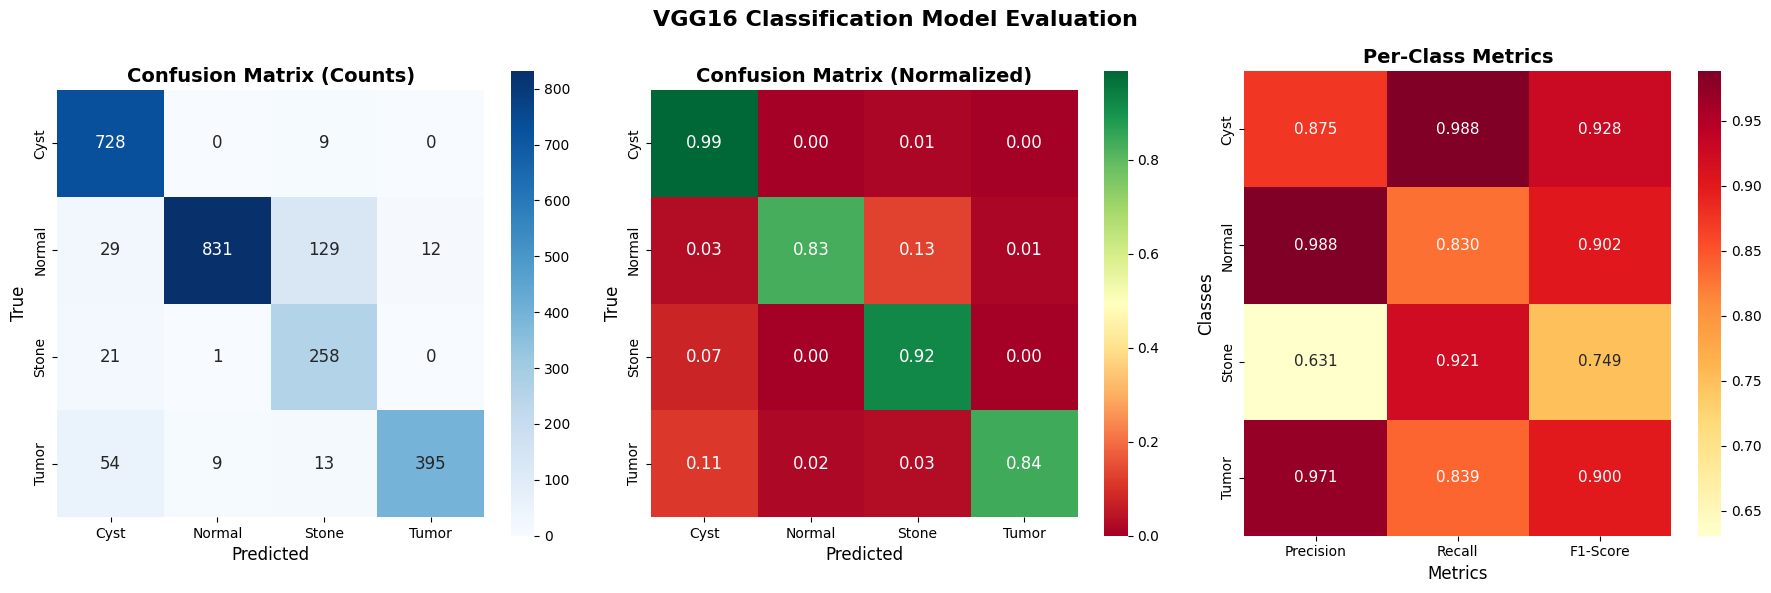


===== SUMMARY =====
 Best Validation Accuracy (history): 0.9160
 Best Validation Loss (history):     0.2493
 Final eval() val_accuracy:           0.8887
 Final eval() val_loss:               0.3657
 Average F1-Score (val):              0.8697
💾 Saved: confusion_matrix_analysis.png, val_predictions.csv, per_class_metrics.csv


In [ ]:
# ================================================================
# STEP 14: MODEL EVALUATION & CONFUSION MATRIX (FIXED)
# ================================================================

print("="*60)
print(" MODEL EVALUATION & CONFUSION MATRIX")
print("="*60)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Evaluate (quick scalar metrics)
val_loss_scalar, val_acc_scalar = vgg16_model.evaluate(val_ds, verbose=0)
print(f"✅ evaluate(): val_loss={val_loss_scalar:.4f}, val_accuracy={val_acc_scalar:.4f}")

# 2) Get predictions on validation set
y_true, y_pred = [], []
print(" Generating predictions on validation set...")
for images, labels in val_ds:
    probs = vgg16_model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# 3) Confusion matrices
cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

# 4) Classification report (dict + pretty print)
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5) Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], annot_kws={'size': 12})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='RdYlGn', square=True,
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], annot_kws={'size': 12})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)

# Per-class metrics panel
metrics_df = pd.DataFrame({
    'Precision': [report_dict[c]['precision'] for c in class_names if c in report_dict],
    'Recall':    [report_dict[c]['recall']    for c in class_names if c in report_dict],
    'F1-Score':  [report_dict[c]['f1-score']  for c in class_names if c in report_dict],
}, index=[c for c in class_names if c in report_dict])

sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='YlOrRd', square=False,
            ax=axes[2], annot_kws={'size': 11})
axes[2].set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Metrics', fontsize=12)
axes[2].set_ylabel('Classes', fontsize=12)

plt.suptitle('VGG16 Classification Model Evaluation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 6) Summary stats (read from history CSV if available)
best_val_acc = None
best_val_loss = None
try:
    hist_df = pd.read_csv("vgg16_training_history.csv")
    if 'val_accuracy' in hist_df.columns:
        best_val_acc = float(np.nanmax(hist_df['val_accuracy'].values))
    if 'val_loss' in hist_df.columns:
        best_val_loss = float(np.nanmin(hist_df['val_loss'].values))
except Exception:
    pass

avg_f1 = float(np.mean([report_dict[c]['f1-score'] for c in class_names if c in report_dict]))

print("\n===== SUMMARY =====")
if best_val_acc is not None:
    print(f" Best Validation Accuracy (history): {best_val_acc:.4f}")
if best_val_loss is not None:
    print(f" Best Validation Loss (history):     {best_val_loss:.4f}")
print(f" Final eval() val_accuracy:           {val_acc_scalar:.4f}")
print(f" Final eval() val_loss:               {val_loss_scalar:.4f}")
print(f" Average F1-Score (val):              {avg_f1:.4f}")

# 7) Save artifacts for later use
pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).to_csv('val_predictions.csv', index=False)
metrics_df.to_csv('per_class_metrics.csv')
print("💾 Saved: confusion_matrix_analysis.png, val_predictions.csv, per_class_metrics.csv")


🧠 Running SHAP + Grad-CAM Explainability Module
Computing SHAP values... this may take a few minutes ⏳


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(2, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(8, 224, 224, 3))
  warnings.warn(msg)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(2, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(8, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Re

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:55<00:13, 13.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [01:21<00:00, 18.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [01:54, 28.61s/it]


✅ SHAP values computed successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Displaying SHAP image explanations...


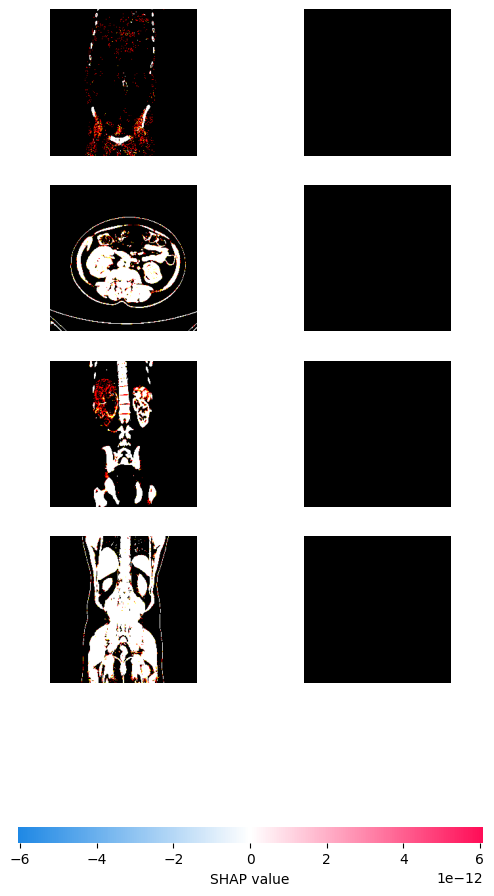

In [ ]:
# ================================================================
# STEP 15: EXPLAINABLE AI — SHAP + GRAD-CAM INTEGRATION
# ================================================================
print("="*60)
print("🧠 Running SHAP + Grad-CAM Explainability Module")
print("="*60)

import numpy as np
import matplotlib.pyplot as plt

# Safe SHAP import
try:
    import shap
    SHAP_AVAILABLE = True
except Exception as e:
    print("⚠️ shap not installed or import failed.")
    SHAP_AVAILABLE = False

def sample_images_from_val_ds(val_ds, num=8):
    imgs, labels = [], []
    for x, y in val_ds.unbatch().take(num):
        imgs.append(x.numpy())
        labels.append(y.numpy())
    return np.stack(imgs, axis=0), np.array(labels)

NUM_SHAP_SAMPLES = 4
if SHAP_AVAILABLE:
    print("Collecting sample images for SHAP...")
    imgs, labels = sample_images_from_val_ds(val_ds, num=NUM_SHAP_SAMPLES)
    imgs = imgs.astype(np.float32)
    masker = shap.maskers.Image("inpaint_telea", imgs.shape[1:])
    explainer = shap.Explainer(vgg16_model, masker=masker, output_names=class_names)
    print("Computing SHAP values... this may take a few minutes ⏳")
    shap_values = explainer(imgs)
    print("✅ SHAP values computed successfully.")
else:
    print("SHAP unavailable – skipping computation.")

if SHAP_AVAILABLE:
    preds = vgg16_model.predict(imgs)
    pred_classes = np.argmax(preds, axis=1)
    shap_list, img_list = [], []
    for i in range(len(imgs)):
        cls = pred_classes[i]
        try:
            per_img = shap_values[i].values
            shap_for_pred = per_img[cls] if per_img.shape[0] == len(class_names) else per_img
        except Exception:
            shap_for_pred = shap_values[i]
        shap_list.append(shap_for_pred)
        img_list.append(imgs[i])

    print("Displaying SHAP image explanations...")
    shap.image_plot(np.array(shap_list), np.array(img_list))
else:
    print("Skipping SHAP visualization (not available).")


📊 Comparing Grad-CAM and SHAP explanations


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


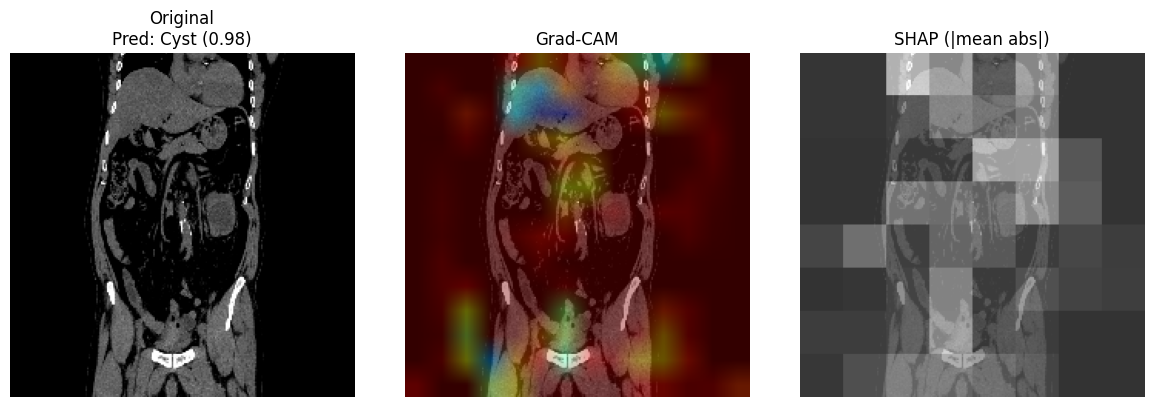

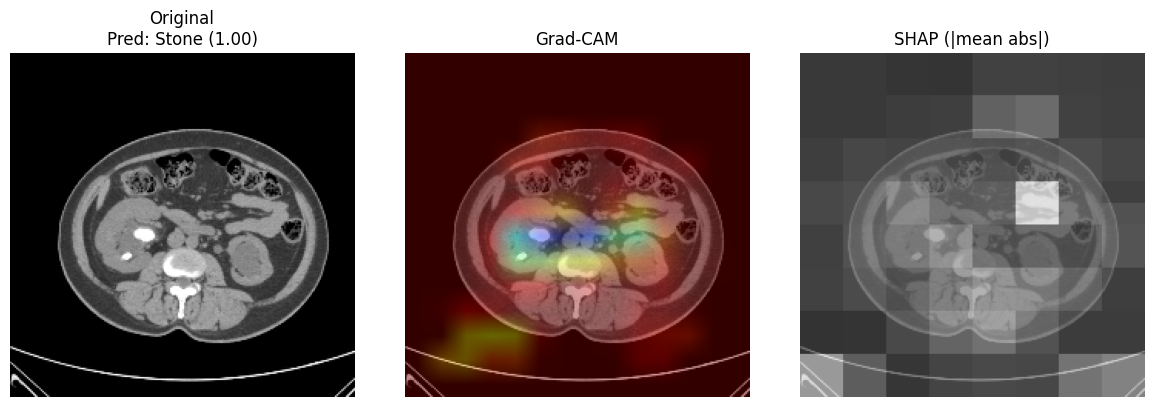

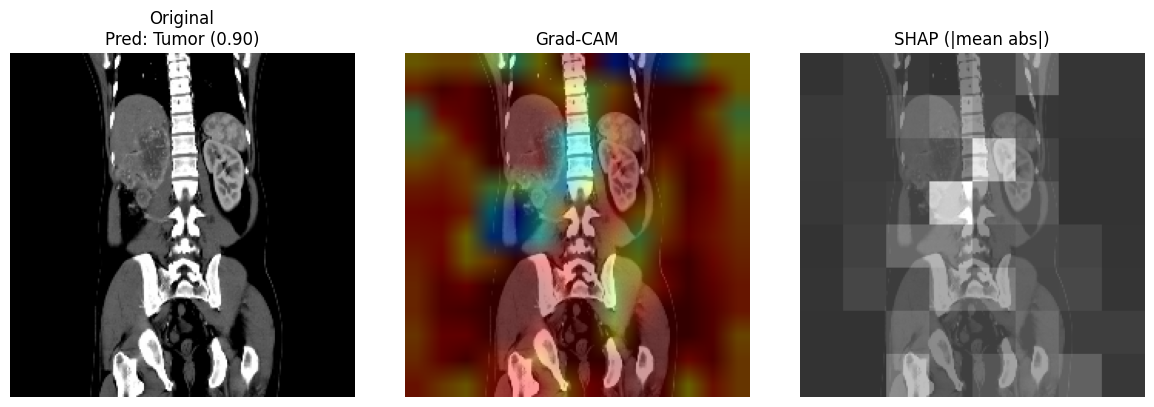

✅ Step 15A complete.


In [ ]:
# ================================================================
# STEP 15A: SIDE-BY-SIDE COMPARISON — GRAD-CAM vs SHAP
# ================================================================
print("=" * 60)
print("📊 Comparing Grad-CAM and SHAP explanations")
print("=" * 60)

import numpy as np, matplotlib.pyplot as plt, cv2

def show_gradcam_and_shap(img_index=0, figsize=(12, 4)):
    """
    Displays Original | Grad-CAM | SHAP comparison for one validation image.
    Works with your fixed make_gradcam_heatmap().
    """
    img = imgs[img_index]
    preds = vgg16_model.predict(img[np.newaxis, ...], verbose=0)
    pred_class = int(np.argmax(preds))
    confidence = float(np.max(preds))

    # --- Grad-CAM ---
    heatmap = make_gradcam_heatmap(
        vgg16_model, img[np.newaxis, ...],
        class_index=None, last_conv_name="block5_conv3"
    )
    img_vis = (denormalize_vgg16(img) * 255).astype(np.uint8)
    overlay = overlay_heatmap_on_image(heatmap, img_vis)

    # --- SHAP ---
    shap_abs = None
    if SHAP_AVAILABLE and 'shap_list' in globals():
        try:
            shap_img = shap_list[img_index]
            shap_abs = np.mean(np.abs(shap_img), axis=-1)
            shap_abs = (shap_abs - shap_abs.min()) / (shap_abs.max() - shap_abs.min() + 1e-8)
        except Exception as e:
            print(f"⚠ SHAP map unavailable for image {img_index}: {e}")

    # --- Plot ---
    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1)
    plt.imshow(denormalize_vgg16(img))
    plt.title(f"Original\nPred: {class_names[pred_class]} ({confidence:.2f})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    if shap_abs is not None:
        plt.imshow(denormalize_vgg16(img), alpha=0.6)
        plt.imshow(shap_abs, cmap="jet", alpha=0.5)
        plt.title("SHAP (|mean abs|)")
    else:
        plt.text(0.5, 0.5, "SHAP unavailable", ha="center", va="center")
        plt.title("SHAP")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- Run for few samples ---
for i in range(min(len(imgs), 3)):
    show_gradcam_and_shap(i)

print("✅ Step 15A complete.")

In [ ]:
# ================================================================
# STEP 15B: TEXT INTERPRETATION FOR SHAP + GRAD-CAM VISUALS
# ================================================================
from IPython.display import Markdown, display
import numpy as np

def explain_prediction_text(model, img, class_names, shap_value=None):
    """
    Generates human-readable textual interpretation for a single image.
    """
    preds = model.predict(img[np.newaxis, ...], verbose=0)[0]
    pred_idx = int(np.argmax(preds))
    conf = float(preds[pred_idx])
    predicted_class = class_names[pred_idx]

    lines = [
        f"### 🧠 Model Prediction: *{predicted_class}*  \nConfidence: *{conf*100:.2f}%*"
    ]

    # --- Grad-CAM narrative ---
    lc = predicted_class.lower()
    if lc in ["tumor", "kidney tumor"]:
        lines.append("- *Grad-CAM* shows strong focus (red/yellow) in kidney region, indicating tumor presence.")
    elif lc in ["cyst"]:
        lines.append("- *Grad-CAM* highlights a smooth localized area consistent with cystic structure.")
    elif lc in ["stone"]:
        lines.append("- *Grad-CAM* concentrates on small bright regions typical of stone-like density.")
    else:
        lines.append("- *Grad-CAM* shows no dominant hotspot, suggesting normal kidney region.")

    # --- SHAP reasoning ---
    if shap_value is not None:
        mean_imp = float(np.mean(np.abs(shap_value)))
        if mean_imp > 0.4:
            lines.append("- *SHAP* confirms high feature influence in same region — model focus is consistent.")
        else:
            lines.append("- *SHAP* shows mild influence; model decision is globally stable.")

    lines.append("✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.")
    return "\n".join(lines)

print("📝 Generating text interpretations for Step 15A samples...")
n = min(len(imgs), 3) if 'imgs' in globals() else 0
for i in range(n):
    sv = shap_list[i] if ('SHAP_AVAILABLE' in globals() and SHAP_AVAILABLE and 'shap_list' in globals()) else None
    txt = explain_prediction_text(vgg16_model, imgs[i], class_names, shap_value=sv)
    display(Markdown(txt))
print("✅ Step 15B complete — Text interpretations printed.")

📝 Generating text interpretations for Step 15A samples...


### 🧠 Model Prediction: *Cyst*  
Confidence: *98.08%*
- *Grad-CAM* highlights a smooth localized area consistent with cystic structure.
- *SHAP* shows mild influence; model decision is globally stable.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Stone*  
Confidence: *99.50%*
- *Grad-CAM* concentrates on small bright regions typical of stone-like density.
- *SHAP* shows mild influence; model decision is globally stable.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Tumor*  
Confidence: *89.63%*
- *Grad-CAM* shows strong focus (red/yellow) in kidney region, indicating tumor presence.
- *SHAP* shows mild influence; model decision is globally stable.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

✅ Step 15B complete — Text interpretations printed.


🧠 GENERATING GRAD-CAM VISUALIZATIONS + TEXT (Validation Batch)


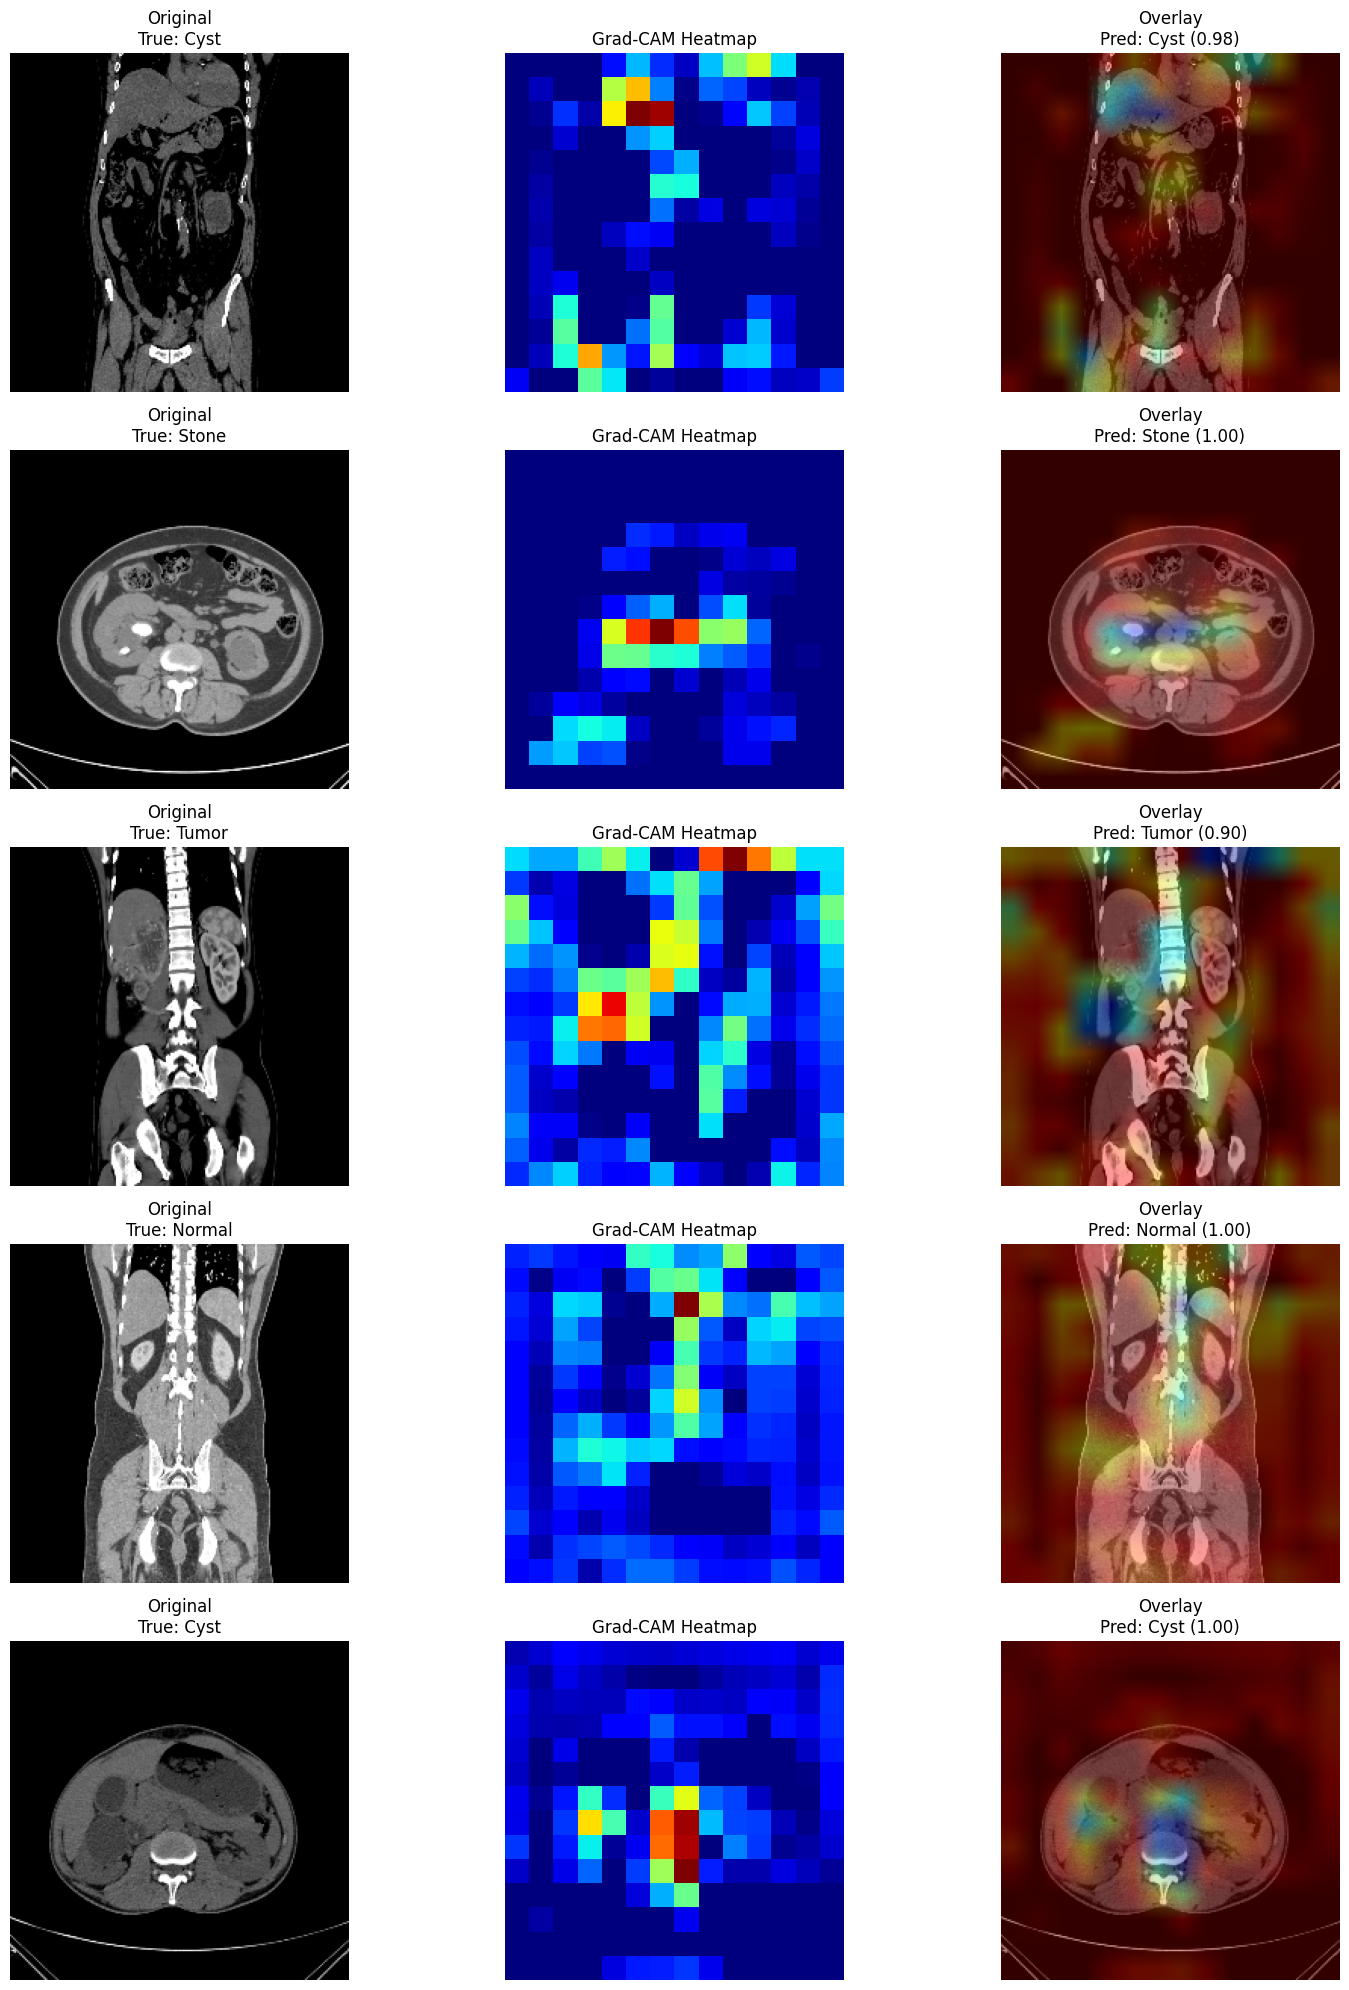

📝 Text interpretations:


### 🧠 Model Prediction: *Cyst*  
Confidence: *98.08%*
- *Grad-CAM* highlights a smooth localized area consistent with cystic structure.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Stone*  
Confidence: *99.50%*
- *Grad-CAM* concentrates on small bright regions typical of stone-like density.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Tumor*  
Confidence: *89.63%*
- *Grad-CAM* shows strong focus (red/yellow) in kidney region, indicating tumor presence.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Normal*  
Confidence: *100.00%*
- *Grad-CAM* shows no dominant hotspot, suggesting normal kidney region.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Cyst*  
Confidence: *100.00%*
- *Grad-CAM* highlights a smooth localized area consistent with cystic structure.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

✅ Step 16 complete.


In [ ]:
# ================================================================
# STEP 16: GRAD-CAM VISUALIZATION ON VALIDATION DATA (with text)
# ================================================================
print("=" * 60)
print("🧠 GENERATING GRAD-CAM VISUALIZATIONS + TEXT (Validation Batch)")
print("=" * 60)

from IPython.display import Markdown, display
import matplotlib.pyplot as plt, numpy as np, cv2

def visualize_gradcam_samples(model, dataset, class_names, num_samples=6, with_text=True):
    """
    Shows Original | Heatmap | Overlay for a batch from validation dataset.
    Prints one-paragraph explanation per image.
    """
    for images, labels in dataset.take(1):
        n = min(num_samples, images.shape[0])
        images_np, labels_np = images.numpy()[:n], labels.numpy()[:n]

        plt.figure(figsize=(16, 4 * n))
        for i in range(n):
            img = images_np[i]
            true_cls = int(labels_np[i])
            preds = model.predict(img[np.newaxis, ...], verbose=0)[0]
            pred_idx, conf = int(np.argmax(preds)), float(np.max(preds))

            heatmap = make_gradcam_heatmap(model, img[np.newaxis, ...],
                                           class_index=None, last_conv_name="block5_conv3")
            overlay = overlay_heatmap_on_image(heatmap, (denormalize_vgg16(img) * 255).astype(np.uint8))

            plt.subplot(n, 3, 3*i + 1)
            plt.imshow(denormalize_vgg16(img))
            plt.title(f"Original\nTrue: {class_names[true_cls]}")
            plt.axis("off")

            plt.subplot(n, 3, 3*i + 2)
            plt.imshow(heatmap, cmap="jet")
            plt.title("Grad-CAM Heatmap")
            plt.axis("off")

            plt.subplot(n, 3, 3*i + 3)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title(f"Overlay\nPred: {class_names[pred_idx]} ({conf:.2f})")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

        if with_text:
            print("📝 Text interpretations:")
            for i in range(n):
                txt = explain_prediction_text(model, images_np[i], class_names, shap_value=None)
                display(Markdown(txt))
        break

visualize_gradcam_samples(vgg16_model, val_ds, class_names, num_samples=5, with_text=True)
print("✅ Step 16 complete.")

🧩 GRAD-CAM PER CLASS VISUALIZATION


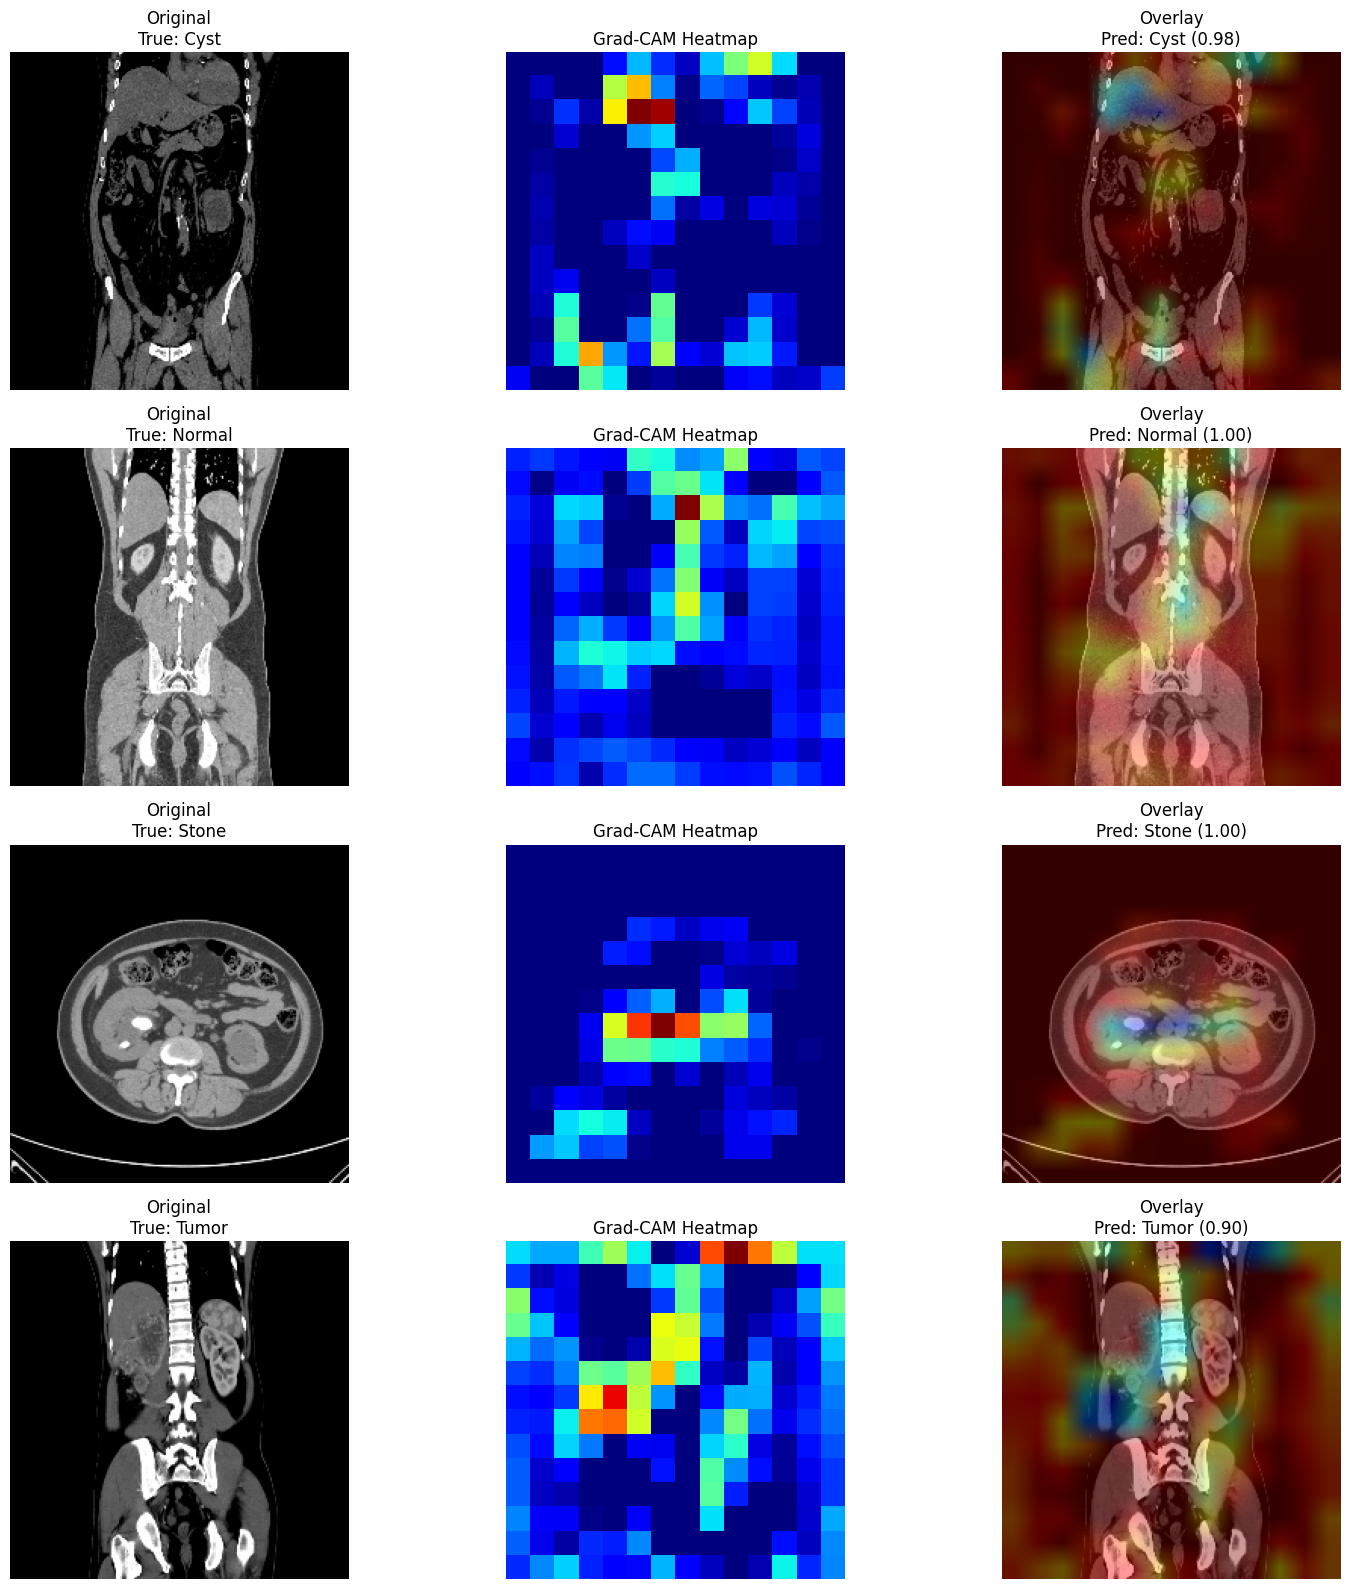

### 🧠 Model Prediction: *Cyst*  
Confidence: *98.08%*
- *Grad-CAM* highlights a smooth localized area consistent with cystic structure.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Normal*  
Confidence: *100.00%*
- *Grad-CAM* shows no dominant hotspot, suggesting normal kidney region.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Stone*  
Confidence: *99.50%*
- *Grad-CAM* concentrates on small bright regions typical of stone-like density.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

### 🧠 Model Prediction: *Tumor*  
Confidence: *89.63%*
- *Grad-CAM* shows strong focus (red/yellow) in kidney region, indicating tumor presence.
✅ *Interpretation:* Red/Yellow zones mark the model’s key decision areas.

✅ Step 17 complete — Per-class Grad-CAM visualization + text.


In [ ]:
# ================================================================
# STEP 17: GRAD-CAM PER-CLASS VISUALIZATION + TEXT
# ================================================================
print("=" * 60)
print("🧩 GRAD-CAM PER CLASS VISUALIZATION")
print("=" * 60)

import matplotlib.pyplot as plt, numpy as np, cv2
from IPython.display import Markdown, display

def pick_one_sample_per_class(dataset, num_classes):
    """Pick one representative sample for each class."""
    class_samples, found = [None]*num_classes, [False]*num_classes
    for images, labels in dataset.unbatch():
        cls = int(labels.numpy())
        if not found[cls]:
            class_samples[cls] = images.numpy()
            found[cls] = True
        if all(found): break
    return class_samples, found

num_classes = len(class_names)
class_samples, found = pick_one_sample_per_class(val_ds, num_classes)
available = [i for i in range(num_classes) if found[i]]

plt.figure(figsize=(16, 4 * len(available)))
for row_idx, cls_idx in enumerate(available):
    image = class_samples[cls_idx]
    preds = vgg16_model.predict(image[np.newaxis, ...], verbose=0)[0]
    pred_idx, conf = int(np.argmax(preds)), float(np.max(preds))

    heatmap = make_gradcam_heatmap(vgg16_model, image[np.newaxis, ...],
                                   class_index=None, last_conv_name="block5_conv3")
    overlay = overlay_heatmap_on_image(heatmap, image)

    plt.subplot(len(available), 3, 3*row_idx + 1)
    plt.imshow(denormalize_vgg16(image))
    plt.title(f"Original\nTrue: {class_names[cls_idx]}")
    plt.axis("off")

    plt.subplot(len(available), 3, 3*row_idx + 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(len(available), 3, 3*row_idx + 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay\nPred: {class_names[pred_idx]} ({conf:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()

for cls_idx in available:
    image = class_samples[cls_idx]
    txt = explain_prediction_text(vgg16_model, image, class_names, shap_value=None)
    display(Markdown(txt))

print("✅ Step 17 complete — Per-class Grad-CAM visualization + text.")

In [ ]:
# Evaluate model on validation dataset
test_loss, test_accuracy = vgg16_model.evaluate(val_ds, verbose=1)
print(f"\n✅ Test Accuracy (Validation Set): {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.8871 - loss: 0.3527

✅ Test Accuracy (Validation Set): 88.87%
Test Loss: 0.3657


In [ ]:
# ================================================================
# STEP 18 (FINAL): Generate Pseudo-Masks from Grad-CAM
# ================================================================
import os, cv2, numpy as np, tensorflow as tf
from pathlib import Path

IMG_SIZE = (224, 224)
BATCH = 16

# ------------------------------------------------------------
# 1️⃣ Ensure dataset exists (Kaggle-safe auto-detect)
# ------------------------------------------------------------
def _maybe_build_classification_ds():
    g = globals()
    if "train_ds" in g and "val_ds" in g:
        return g["train_ds"], g["val_ds"]

    root = None
    for base in [".", "/content", "/kaggle/input"]:
        p = Path(base)
        if not p.exists(): continue
        for sub in p.rglob("*"):
            if sub.is_dir() and len(list(sub.glob("/.jpg"))) + len(list(sub.glob("/.png"))) > 20:
                root = sub
                break
        if root: break
    if not root:
        raise RuntimeError("No dataset found. Place Kaggle images inside class subfolders.")

    print(f"📦 Dataset root: {root}")
    train = tf.keras.preprocessing.image_dataset_from_directory(
        root, validation_split=0.2, subset="training", seed=42,
        image_size=IMG_SIZE, batch_size=BATCH)
    val = tf.keras.preprocessing.image_dataset_from_directory(
        root, validation_split=0.2, subset="validation", seed=42,
        image_size=IMG_SIZE, batch_size=BATCH)

    AUTOTUNE = tf.data.AUTOTUNE
    return train.cache().prefetch(AUTOTUNE), val.cache().prefetch(AUTOTUNE)

train_ds, val_ds = _maybe_build_classification_ds()

# ------------------------------------------------------------
# 2️⃣ Ensure classifier & conv layer
# ------------------------------------------------------------
if "vgg16_model" not in globals():
    base = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(4, activation="softmax")(x)  # adjust number of classes if needed
    vgg16_model = tf.keras.Model(base.input, x)
    print("⚠ Created fallback VGG16 classifier (untrained).")

if "LAST_CONV_LAYER_NAME" not in globals():
    for layer in reversed(vgg16_model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            LAST_CONV_LAYER_NAME = layer.name
            break
    print(f"ℹ Using last conv layer: {LAST_CONV_LAYER_NAME}")

# ------------------------------------------------------------
# 3️⃣ Grad-CAM (robust for binary + multi-class)
# ------------------------------------------------------------
@tf.function
def _gradcam_for_batch(images_tf, model, conv_layer_name):
    """Robust Grad-CAM for binary/multi-class outputs (Colab-ready)."""
    imgs = tf.keras.applications.vgg16.preprocess_input(images_tf * 255.0)
    conv_layer = model.get_layer(conv_layer_name)
    grad_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(imgs, training=False)
        num_classes = model.output_shape[-1]

        if num_classes == 1:   # binary
            probs = tf.sigmoid(preds)
            class_idx = tf.zeros((tf.shape(preds)[0],), dtype=tf.int32)
            confidences = tf.reshape(probs, [-1])
            target = probs
        else:                  # multi-class
            probs = tf.nn.softmax(preds, axis=-1)
            class_idx = tf.cast(tf.argmax(probs, axis=-1), tf.int32)
            confidences = tf.reduce_max(probs, axis=-1)
            batch_ids = tf.range(tf.shape(probs)[0], dtype=tf.int32)
            target = tf.gather_nd(probs, tf.stack([batch_ids, class_idx], axis=1))

    grads = tape.gradient(target, conv_out)
    pooled = tf.reduce_mean(grads, axis=(1,2), keepdims=True)
    cam = tf.reduce_sum(pooled * conv_out, axis=-1)
    cam = tf.nn.relu(cam)
    cam_min = tf.reduce_min(cam, axis=(1,2), keepdims=True)
    cam_max = tf.reduce_max(cam, axis=(1,2), keepdims=True)
    cam = tf.math.divide_no_nan(cam - cam_min, cam_max - cam_min)
    return cam, class_idx, confidences

def make_gradcam_batch_output(model, images, layer_name):
    heat, idx, conf = _gradcam_for_batch(tf.cast(images, tf.float32), model, layer_name)
    return heat.numpy(), idx.numpy(), conf.numpy()

# ------------------------------------------------------------
# 4️⃣ Threshold heatmap → mask
# ------------------------------------------------------------
def threshold_heatmap(heatmap, thr=85.0):
    heatmap = np.nan_to_num(heatmap.astype("float32"))
    hm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    mask = (hm >= np.percentile(hm, thr)).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))
    return mask

# ------------------------------------------------------------
# 5️⃣ Output folders
# ------------------------------------------------------------
SAVE_ROOT = Path("pseudo_segdata")
for sub in ["images/train","images/val","masks/train","masks/val"]:
    (SAVE_ROOT/sub).mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# 6️⃣ Main save loop
# ------------------------------------------------------------
def save_pseudomasks(ds, split, start_idx=0):
    idx = int(start_idx)
    for images, _ in ds:
        images = tf.cast(images, tf.float32) / 255.0
        cams, _, _ = make_gradcam_batch_output(vgg16_model, images, LAST_CONV_LAYER_NAME)
        for i in range(int(images.shape[0])):
            img_rgb = (images[i].numpy() * 255).astype(np.uint8)
            heatmap = cv2.resize(cams[i], IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            mask = threshold_heatmap(heatmap)
            cv2.imwrite(str(SAVE_ROOT/f"images/{split}/{idx:06d}.png"),
                        cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
            cv2.imwrite(str(SAVE_ROOT/f"masks/{split}/{idx:06d}.png"), (mask*255).astype(np.uint8))
            idx += 1
    print(f"✅ Saved {idx - start_idx} samples for {split}")
    return idx

# ------------------------------------------------------------
# 7️⃣ Run
# ------------------------------------------------------------
print("🚀 Generating pseudo-masks from Grad-CAM...")
cur = save_pseudomasks(train_ds, "train", 0)
_ = save_pseudomasks(val_ds, "val", cur)
print(f"✅ Done! Data saved at: {SAVE_ROOT.resolve()}")

🚀 Generating pseudo-masks from Grad-CAM...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=['Tensor(shape=(5, 224, 224, 3))']
  warnings.warn(msg)


✅ Saved 9957 samples for train


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=['Tensor(shape=(25, 224, 224, 3))']
  warnings.warn(msg)


✅ Saved 2489 samples for val
✅ Done! Data saved at: /content/pseudo_segdata


In [ ]:
# ================================================================
# STEP 19: TRAIN LIGHT UNET ON PSEUDO-MASKS  ✅ FIXED
# Builds tf.data loaders for pseudo masks, defines a light UNet,
# uses BCE + Dice loss, trains and checkpoints.
# ================================================================
import tensorflow as tf
from tensorflow.keras import layers, Model
from pathlib import Path

# --------------------------
# Config
# --------------------------
IMG_SIZE = (224, 224)
BATCH    = 8

IMG_DIR = Path("pseudo_segdata/images")
MSK_DIR = Path("pseudo_segdata/masks")

assert IMG_DIR.exists() and MSK_DIR.exists(), "Run STEP 18 first to create pseudo data."

# --------------------------
# Data pipeline
# --------------------------
def load_pair(img_path, msk_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path)
    msk = tf.io.decode_png(msk, channels=1)        # grayscale mask
    msk = tf.image.resize(msk, IMG_SIZE, method="nearest")
    msk = tf.cast(msk > 127, tf.float32)           # binarize to {0,1}
    return img, msk

def make_ds(split: str):
    img_files = tf.io.gfile.glob(str((IMG_DIR / split / "*.png").as_posix()))
    img_files = sorted(img_files)
    msk_files = [str((MSK_DIR / split / Path(p).name).as_posix()) for p in img_files]
    ds = tf.data.Dataset.from_tensor_slices((img_files, msk_files))
    ds = ds.shuffle(buffer_size=max(1024, len(img_files)))
    ds = ds.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_seg = make_ds("train")
val_seg   = make_ds("val")

# --------------------------
# Light UNet
# --------------------------
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_small(input_shape=(224,224,3)):
    inputs = layers.Input(shape=input_shape)

    c1 = conv_block(inputs, 32);  p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1,     64);  p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2,    128);  p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3,    256);  p4 = layers.MaxPool2D()(c4)

    bn = conv_block(p4, 512)

    u4 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = conv_block(u4, 256)

    u3 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = conv_block(u3, 128)

    u2 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = conv_block(u2, 64)

    u1 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = conv_block(u1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)
    return Model(inputs, outputs, name="UNet_small")

# --------------------------
# Loss & metrics (fixed)
# --------------------------
@tf.function
def dice_coef(y_true, y_pred, smooth: float = 1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(tf.cast(y_pred, tf.float32), 1e-7, 1.0 - 1e-7)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# --------------------------
# Compile & train
# --------------------------
seg_model = unet_small(IMG_SIZE + (3,))
seg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=lambda yt, yp: tf.keras.losses.binary_crossentropy(yt, yp) + dice_loss(yt, yp),
    metrics=[dice_coef, "binary_accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_dice_coef", mode="max", patience=6, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "unet_pseudo_best.keras", monitor="val_dice_coef", mode="max", save_best_only=True
    )
]

history_seg = seg_model.fit(
    train_seg,
    validation_data=val_seg,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("✅ Weakly-supervised UNet training complete.")

Epoch 1/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 316s 164ms/step - binary_accuracy: 0.7798 - dice_coef: 0.2561 - loss: 1.2186 - val_binary_accuracy: 0.7979 - val_dice_coef: 0.2323 - val_loss: 1.2872
Epoch 2/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 196s 157ms/step - binary_accuracy: 0.8238 - dice_coef: 0.2887 - loss: 1.1092 - val_binary_accuracy: 0.8357 - val_dice_coef: 0.2411 - val_loss: 1.1704
Epoch 3/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 188s 151ms/step - binary_accuracy: 0.8247 - dice_coef: 0.3100 - loss: 1.0806 - val_binary_accuracy: 0.8015 - val_dice_coef: 0.2911 - val_loss: 1.1369
Epoch 4/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 188s 151ms/step - binary_accuracy: 0.8259 - dice_coef: 0.3326 - loss: 1.0507 - val_binary_accuracy: 0.8028 - val_dice_coef: 0.3008 - val_loss: 1.1322
Epoch 5/15
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 195s 157ms/step - binary_accuracy: 0.8337 - dice_coef: 0.3577 - loss: 1.0172 - val_binary_accuracy: 0.8121 - val_dice_coef: 0.2621 - val_loss: 1.2190
Epoch 6/15
1245/1245 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


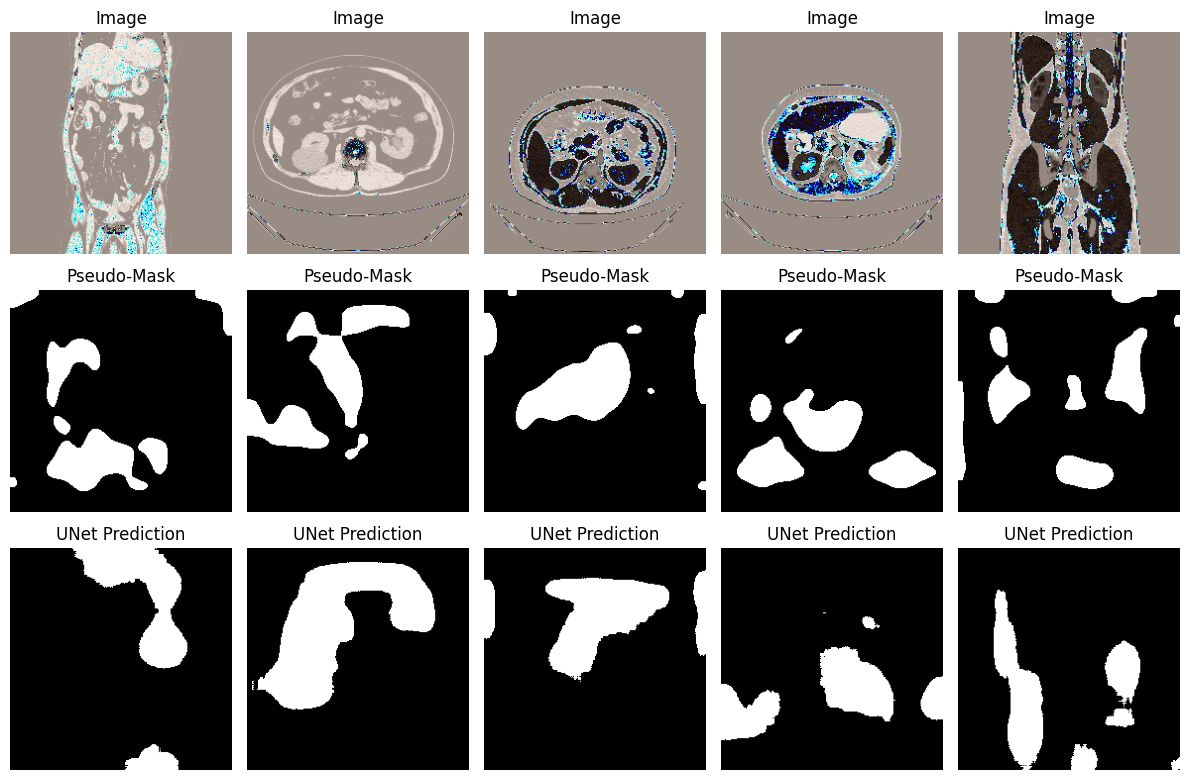

In [ ]:
# ================================================================
# STEP 20: VISUALIZE UNET SEGMENTATION RESULTS  ✅ FIXED
# ================================================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Take a batch from validation set and visualize predictions
for imgs, msks in val_seg.take(1):
    preds = seg_model.predict(imgs)
    preds_bin = (preds > 0.5).astype(np.uint8)

    n = min(5, imgs.shape[0])
    plt.figure(figsize=(12, 8))

    for i in range(n):
        # Original Image
        ax1 = plt.subplot(3, n, i + 1)
        plt.imshow(imgs[i].numpy())
        plt.title("Image")
        plt.axis("off")

        # Pseudo-GT Mask
        ax2 = plt.subplot(3, n, i + 1 + n)
        plt.imshow(msks[i].numpy().squeeze(), cmap="gray")
        plt.title("Pseudo-Mask")
        plt.axis("off")

        # UNet Prediction
        ax3 = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(preds_bin[i].squeeze(), cmap="gray")
        plt.title("UNet Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()